# PyTorch Workflow For Multiclass Classification #

## The objective is to develop a model for multiclass classification and evaluate its capabilities.

### Generate data for multiclass classification
- Let's do for 5 classes
- Visualize the data
- Label the color for each class

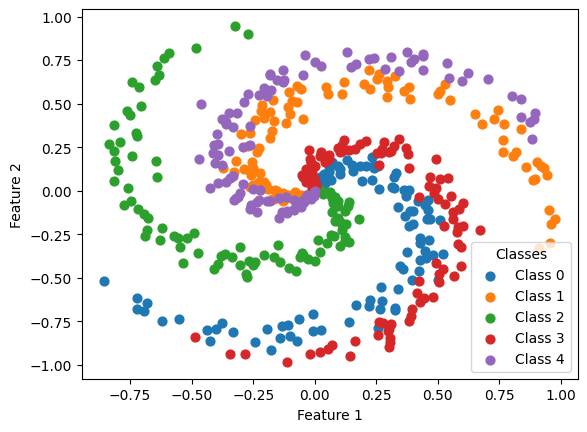

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 100 # number of points per class
D = 2 # dimensionality
K = 5 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# Plot each class separately to include in the legend
for class_label in range(K):
    plt.scatter(X[y == class_label, 0], X[y == class_label, 1], 
                label=f"Class {class_label}", s=40)

# Label axes
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Add legend
plt.legend(title="Classes")

# Show the plot
plt.show()

### Settings for model

In [9]:
import torch

# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert data to tensors + convert to float32
X_torch = torch.from_numpy(X).float().to(device)
y_torch = torch.from_numpy(y).type(torch.LongTensor).to(device)

# Device information
print(f"Data is stored in {device}")

Data is stored in cpu


### Split into training and testing set

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_torch, y_torch, test_size = 0.2, random_state=42)

print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

Training data size: 400
Testing data size: 100


### Hyperparameters for model are as follows:

In [4]:
import torch.nn as nn

inp_dim = len(X_torch[0])
hu_1 = 16
hu_2 = 10

print(f"Classification labels are: {torch.unique(y_torch)}")
out_dim = len(torch.unique(y_torch))
print(f"Number of labels are: {out_dim}")

Classification labels are: tensor([0, 1, 2, 3, 4])
Number of labels are: 5


### Create a class for the multi classification 

In [5]:
# Save all components in nn.Module in multiclass_classification
class model(nn.Module):
    def __init__(self, inp_dim, hu_1, hu_2, out_dim):
        super(model, self).__init__()
        # Define the layers
        self.layer = nn.Sequential(nn.Linear(inp_dim, hu_1),
                                   nn.ReLU(),
                                   nn.Linear(hu_1, hu_2),
                                   nn.ReLU(),
                                   nn.Linear(hu_2, out_dim))
    def forward(self, x):
        x = self.layer(x)
        return x

# Instantiate the model
model = model(inp_dim, hu_1, hu_2, out_dim).to(device)

### Structure of created model

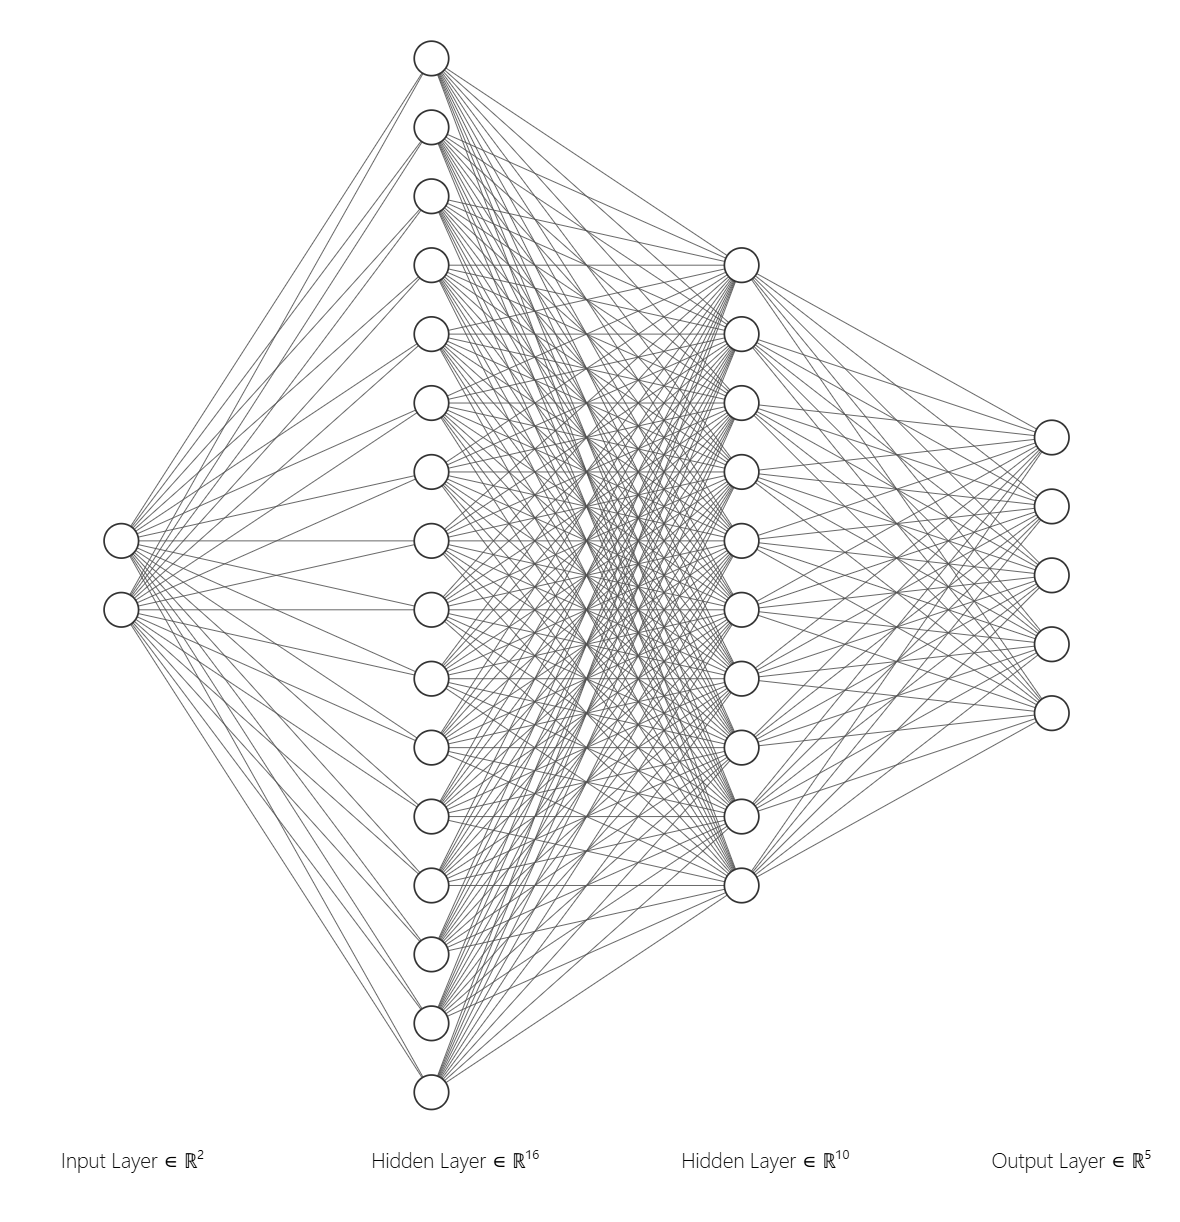


### Functions for model

In [6]:
import torch.optim as optim

# accuracy function
def acc_fn(y_pred, y_actual):
    total = len(y_pred)
    correct = torch.eq(y_pred, y_actual).sum().item()
    acc = (correct/total) * 100
    return acc

# Loss function for multiclass classification
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer for model that adjusts the parameters tto minimize training loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Create a training and testing loop for multi-class classification model

In [7]:
# Set ramdom seed for consistency
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
epochs_list = []
train_losses = []
test_losses = []

for epoch in range(epochs):
    ### TRAINING MODE
    model.train()
    
    ## Forward beginning
    # Predictions on test set
    y_train_logits = model(X_train)                           # logits
    y_train_probs = torch.softmax(y_train_logits, dim=1)      # probability for all classes 
    y_train_labels = torch.argmax(y_train_probs, dim=1)       # max prob selected as label
    
    # Loss on training set
    train_loss = loss_fn(y_train_logits, y_train)
    train_losses.append(train_loss)
    # Accuracy on training set
    train_acc = acc_fn(y_train_labels, y_train)
    
    # Set gradients to zero for each epoch
    optimizer.zero_grad()
    
    ## Backpropagation beginning
    # Gradient of loss for each parameter
    train_loss.backward()
    
    # Update parameters according to gradients
    optimizer.step()
    
    ### TESTING MODE
    model.eval()
    ## Clear gradients
    with torch.inference_mode():
        # Predictions on test set
        y_test_logits = model(X_test)
        y_test_probs = torch.softmax(y_test_logits, dim=1)
        y_test_labels = torch.argmax(y_test_probs, dim=1)
        
        # loss on test set
        test_loss = loss_fn(y_test_logits, y_test)
        test_losses.append(test_loss)
        # Accuracy on test set
        test_acc = acc_fn(y_test_labels, y_test)
        
        # Print every 100 epochs for monitoring improvement
        if (epoch+1) % 100==0:
            print(f"Epoch:{epoch+1} | Training Loss:{train_loss:.5f} | Training Accuracy:{train_acc:.2f} | Testing Loss{test_loss:5f} | Testing Accuracy:{test_acc:.2f}")

Epoch:100 | Training Loss:0.88854 | Training Accuracy:53.50 | Testing Loss0.898851 | Testing Accuracy:55.00
Epoch:200 | Training Loss:0.46882 | Training Accuracy:83.25 | Testing Loss0.616089 | Testing Accuracy:68.00
Epoch:300 | Training Loss:0.28135 | Training Accuracy:89.00 | Testing Loss0.358380 | Testing Accuracy:85.00
Epoch:400 | Training Loss:0.22176 | Training Accuracy:91.75 | Testing Loss0.318012 | Testing Accuracy:86.00
Epoch:500 | Training Loss:0.20054 | Training Accuracy:92.25 | Testing Loss0.321335 | Testing Accuracy:87.00
Epoch:600 | Training Loss:0.18663 | Training Accuracy:92.50 | Testing Loss0.321643 | Testing Accuracy:87.00
Epoch:700 | Training Loss:0.17435 | Training Accuracy:92.25 | Testing Loss0.333898 | Testing Accuracy:87.00
Epoch:800 | Training Loss:0.16316 | Training Accuracy:94.00 | Testing Loss0.351631 | Testing Accuracy:85.00
Epoch:900 | Training Loss:0.15394 | Training Accuracy:94.00 | Testing Loss0.347052 | Testing Accuracy:86.00
Epoch:1000 | Training Loss:0

### To visualize, the predictions for classification, let's use a Confusion Matrix for both on the train and test sets.

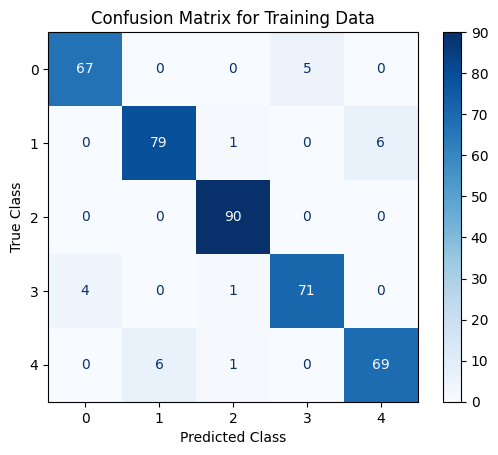

None


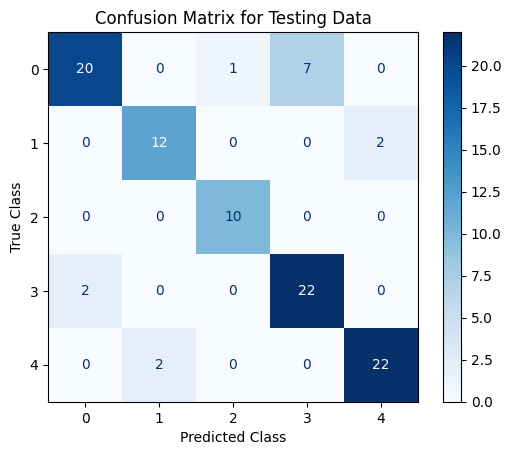

None


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, num_classes, title):
    """
    Plots a confusion matrix using sklearn's ConfusionMatrixDisplay.

    Args:
        y_true (array-like): True labels (ground truth).
        y_pred (array-like): Predicted labels.
        num_classes (int): Number of classes in the classification task.
        title (str): Title for the confusion matrix plot. Default is "Confusion Matrix".

    Returns:
        None: Displays the confusion matrix plot.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues)

    # Label the axes and set the title
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for {title}")

    # Show the plot
    plt.show()
    
# Training data
print(plot_confusion_matrix(y_train, y_train_labels, out_dim, "Training Data"))
# Testing data
print(plot_confusion_matrix(y_test, y_test_labels, out_dim, "Testing Data"))